# PedSilicoICH: Part 2. Scanners

This notebook also introduces concepts of the `Scanners` Class, and assumes familiarity with the [01_phantoms.ipynb](01_phantoms.ipynb) notebook and continues from it.

In [1]:
%pip install --upgrade pip -q
%pip install matplotlib -q ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


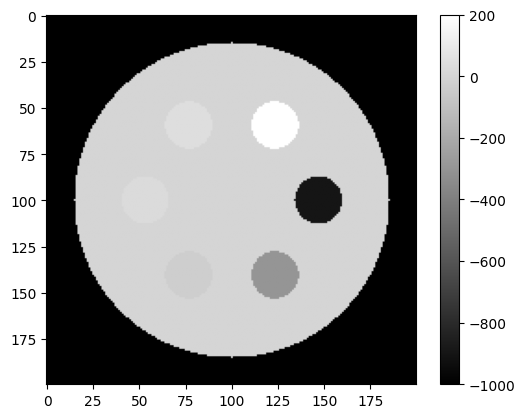

In [2]:
import matplotlib.pyplot as plt

from utils import create_circle_phantom

circles = [-900, -300, -30, 30, 45, 200]
img = create_circle_phantom(image_size=200,
                            large_circle_value=0,
                            bg_value=-1000,
                            small_circle_values=circles,
                            num_small_circles=len(circles))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [3]:
from VITools import Phantom, Scanner
phantom = Phantom(img[None], spacings=(200, 1, 1))
scanner = Scanner(phantom)
scanner

Initializing Scanner object...
----------
*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 1.0-mm pixels (XY), 200.0-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ncat_adipose', 'ncat_water', 'ncat_brain', 'ncat_skull']
* mu values (/cm): [0.18, 0.21, 0.21, 0.46]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.16, 0.2, 0.21, 0.27]
* Thresholds (HU): [-200.0, -10.0, 10.0, 300.0]
*********************************************
* Calculating volume fraction maps for 4 materials and 1 slices...
* Writing volume fraction files for 4 materials and 1 slices, plus the HU data...
* Writing /tmp/tmpunikbcj3/default/phantoms/0


        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        

In [4]:
class PhotonCountingScanner(Scanner):
    def __init__(self, *args, scanner_model='Scanner_PCCT', **kwargs):
        super().__init__(*args, scanner_model=scanner_model, **kwargs)

    def run_scan(self, *args, sum_bins=False, **kwargs):
        self.xcist.cfg.scanner.detectorSumBins = sum_bins
        if not self.xcist.cfg.scanner.detectorSumBins:
            self.xcist.do_prep = 0
        super().run_scan(*args, **kwargs)

    def run_recon(self, *args, threshold=70, enoise_threshold=True, **kwargs):
        '''
        threshold: kV threshold to split energy bins into upper and lower energy
        See Scanner.run_recon for *args, and **kwargs definitions.

        Returns self.recon as [bins, slices, rows, cols] with low energy, high energy
        '''
        neglog_lower, neglog_upper = self.threshold_sum(threshold, enoise_threshold)
        # first lower energy bin
        original_projections = self._projections
        original_name = self.xcist.resultsName
        if len(self._projections) > 1:
            for i in range(len(self._projections)):
                self._projections[i] = original_projections[i] + f'_thresh_{threshold}kV_lower'
                xc.rawwrite(self._projections[i]+'.prep', neglog_lower)
        else:
            self.xcist.resultsName = original_name + f'_thresh_{threshold}kV_lower'
            self.xcist.cfg.resultsName = self.xcist.resultsName
            self._projections = [o + f'_thresh_{threshold}kV_lower' for o in original_projections]
            xc.rawwrite(self.xcist.resultsName+'.prep', neglog_lower)
        print(f'reconstructing: {self.xcist.resultsName}')
        super().run_recon(*args, **kwargs)
        proj_lower = self.projections.copy()
        recon_lower = self.recon.copy()
        self.xcist.resultsName = original_name
        self.xcist.cfg.resultsName = self.xcist.resultsName
        self._projections = original_projections
        
        # now upper
        original_projections = self._projections
        original_name = self.xcist.resultsName
        if len(self._projections) > 1:
            for i in range(len(self._projections)):
                self._projections[i] = original_projections[i] + f'_thresh_{threshold}kV_upper'
                xc.rawwrite(self._projections[i]+'.prep', neglog_upper)
        else:
            self.xcist.resultsName = original_name + f'_thresh_{threshold}kV_upper'
            self.xcist.cfg.resultsName = self.xcist.resultsName
            self._projections = [o + f'_thresh_{threshold}kV_upper' for o in original_projections]
            xc.rawwrite(self.xcist.resultsName+'.prep', neglog_upper)
        print(f'reconstructing: {self.xcist.resultsName}')
        super().run_recon(*args, **kwargs)
        proj_upper = self.projections.copy()
        recon_upper = self.recon.copy()       
        self.xcist.resultsName = original_name
        self.xcist.cfg.resultsName = self.xcist.resultsName
        self._projections = original_projections

        self.projections = np.stack([proj_lower, proj_upper])
        self.recon = np.stack([recon_lower, recon_upper])

    def threshold_sum(self, thresh, enoise_threshold):
        ct = self.xcist
        nBin = len(ct.scanner.detectorBinThreshold)-1
        scan = xc.rawread(ct.resultsName + '.scan', [ct.protocol.viewCount,
                                                     ct.scanner.detectorRowCount,
                                                     ct.scanner.detectorColCount, nBin], 'float')
        offset = xc.rawread(ct.resultsName + '.offset', [ct.scanner.detectorRowCount,
                                                         ct.scanner.detectorColCount, nBin], 'float')
        air = xc.rawread(ct.resultsName + '.air', [ct.scanner.detectorRowCount,
                                                   ct.scanner.detectorColCount, nBin], 'float')

        bins = np.array(ct.scanner.detectorBinThreshold)[:-1]

        if enoise_threshold:
            scan_lower = scan[:, :, :, (25 < bins) & (bins < thresh)]
        else:
            scan_lower = scan[:, :, :, bins < thresh]
        scan_upper = scan[:, :, :, bins >= thresh]

        if enoise_threshold:
            air_lower = air[:, :, (25 < bins) & (bins < thresh)]
        else:
            air_lower = air[:, :, bins < thresh]
        air_upper = air[:, :, bins >= thresh]

        if enoise_threshold:
            offset_lower = offset[:, :, (25 < bins) & (bins < thresh)]
        else:
            offset_lower = offset[:, :, bins < thresh]
        offset_upper = offset[:, :, bins >= thresh]
        #
        scan_lower_sum = scan_lower.sum(axis=-1)
        scan_upper_sum = scan_upper.sum(axis=-1)

        air_lower_sum = air_lower.sum(axis=-1)
        air_upper_sum = air_upper.sum(axis=-1)

        offset_lower_sum = offset_lower.sum(axis=-1)
        offset_upper_sum = offset_upper.sum(axis=-1)

        neglog_lower = -np.log((scan_lower_sum - offset_lower_sum)/
                               (air_lower_sum - offset_lower_sum))
        neglog_upper = -np.log((scan_upper_sum - offset_upper_sum)/
                               (air_upper_sum - offset_upper_sum))
        return neglog_lower, neglog_upper

## Use `scanner.scout_view()` to determine scan range

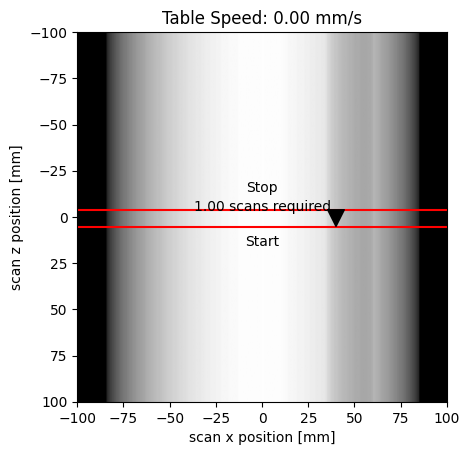

In [4]:
scans = 1  # edit me

center = 0
scan_width = 7
width = scan_width*scans
startZ = center - width / 2
endZ = center + width / 2

scanner.scout_view(startZ, endZ)

In [5]:
acquisition_technique = dict(
    mA=200,
    kVp=120,
    views=500,
    startZ=startZ,
    endZ=endZ
)
scanner.run_scan(**acquisition_technique)

scan: 1/1
Airscan


Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        

In [6]:
recon_technique = dict(
    kernel='standard',
    fov=250,
    slice_thickness=1,
    slice_increment=1
)
scanner.run_recon(**recon_technique)

fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...



        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (500, 16, 900)

## View the result

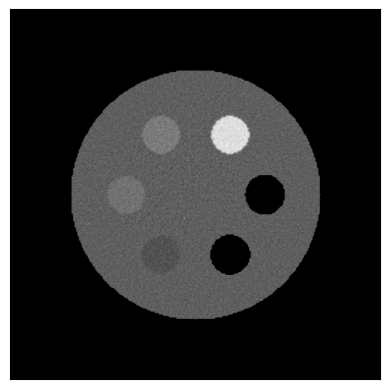

In [7]:
from utils import ctshow
ctshow(scanner.recon)

In [8]:
scanner.write_to_dicom('CTP404/CTP404.dcm')

[PosixPath('CTP404/CTP404_000.dcm'),
 PosixPath('CTP404/CTP404_001.dcm'),
 PosixPath('CTP404/CTP404_002.dcm'),
 PosixPath('CTP404/CTP404_003.dcm'),
 PosixPath('CTP404/CTP404_004.dcm'),
 PosixPath('CTP404/CTP404_005.dcm'),
 PosixPath('CTP404/CTP404_006.dcm')]

In [9]:
mAs = [20, 80, 320]
mA_recons = []
for mA in mAs:
    scanner.run_scan(mA=mA, startZ=startZ, endZ=endZ, views=500)
    scanner.run_recon(slice_thickness=1, kernel='soft')
    mA_recons.append(scanner.recon)

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:05<00:00,  2.69it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:13<00:00,  2.58it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


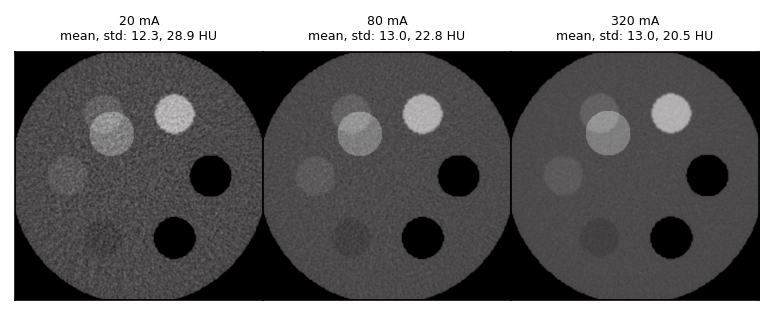

In [10]:
from utils import ctshow, center_crop, center_crop_like, circle_select
import matplotlib.pyplot as plt

roi_params = dict(
    xy = (200, 220),
    r=30
)

show_roi = True

f, axs = plt.subplots(1, len(mA_recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, mA in zip(axs.flatten(), mA_recons, mAs):
    ctshow(center_crop(recon[0]), fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{mA} mA\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [11]:
kVps = [80, 100, 120, 140]
kVp_recons = []
for kVp in kVps:
    mA = 200 * (120 / kVp)**2 # accounts for the fact that tube output scales by kVp^2
    print(f'{kVp} kVp, {mA} mA')
    scanner.run_scan(kVp=kVp, mA=mA, startZ=startZ, endZ=endZ, views=500)
    scanner.run_recon(slice_thickness=1, kernel='soft')
    kVp_recons.append(scanner.recon)

80 kVp, 450.0 mA
scan: 1/1
Airscan


Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
100 kVp, 288.0 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
120 kVp, 200.0 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
140 kVp, 146.93877551020407 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


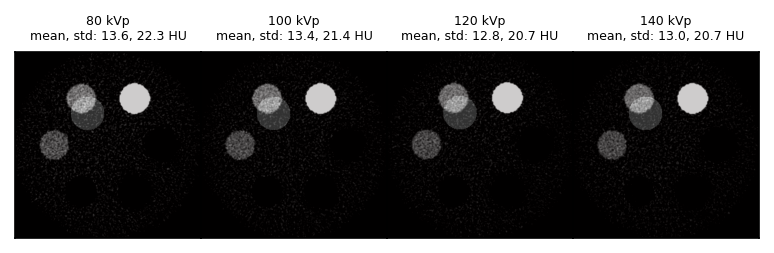

In [12]:
show_roi = True

f, axs = plt.subplots(1, len(kVp_recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, kVp in zip(axs.flatten(), kVp_recons, kVps):
    ctshow(center_crop(recon[0]), 'brain', fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{kVp} kVp\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [13]:
scanner.run_scan(kVp=120, mA=200, startZ=startZ, endZ=endZ, views=500)

scan: 1/1
Airscan


Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (500, 16, 900)

In [14]:
kernels = ['bone', 'standard', 'soft']

recons = []
for kernel in kernels:
    scanner.run_recon(slice_thickness=1, kernel=kernel)
    recons.append(scanner.recon)

fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...


* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


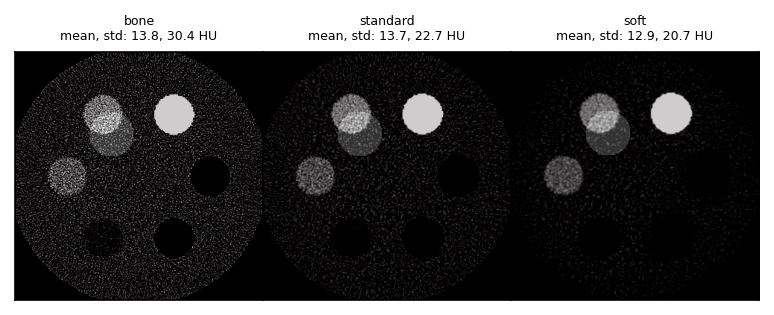

In [15]:
show_roi = True

f, axs = plt.subplots(1, len(recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, kernel in zip(axs.flatten(), recons, kernels):
    ctshow(center_crop(recon[0]), 'brain', fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{kernel}\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [16]:
from VITools import Study

In [17]:
study = Study(scanner)
study


Input metadata:

Empty DataFrame
Columns: []
Index: []

Results:

Empty DataFrame
Columns: []
Index: []

In [18]:
study.run_study?

Signature: study.run_study(patientid: int = 0)
Docstring:
Runs a single simulation study for a specific patient/case ID.

This method orchestrates the simulation for one entry in the
`self.metadata` DataFrame. It involves:
1. Initializing the specified phantom.
2. Setting up the virtual scanner.
3. Determining the scan range (z-axis coverage).
4. Running the scan (projection data generation).
5. Running the reconstruction.
6. Writing the reconstructed images to DICOM files.
7. Saving metadata about the scan.
8. Optionally, removing raw projection data.

Args:
    patientid (int, optional):
        The index of the scan configuration in `self.metadata` to run.
        Defaults to 0 (the first scan).

Returns:
    Study: The Study instance itself.

Raises:
    KeyError: If the phantom specified in the metadata is not found.
    IndexError: If `patientid` is out of bounds for `self.metadata`.
File:      /scratch/brandon.nelson/VITools/.vitools/lib/python3.13/site-packages/VITools/study.py

In [19]:
study.run_study(zspan=(startZ, endZ))

TypeError: Study.run_study() got an unexpected keyword argument 'zspan'

In [ ]:
study.metadata

,Name,Age,kVp,mA,Views,ReconKernel,SliceThickness(mm),LesionAttenuation(HU),LesionVolume(mL),Subtype,MassEffect,CenterX,CenterY,CenterZ,FOV(mm),ImageFilePath,MaskFilePath
0,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_000.dcm,None
1,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_001.dcm,None
2,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_002.dcm,None
3,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_003.dcm,None
4,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_004.dcm,None
5,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_005.dcm,None
6,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_006.dcm,None
